<a href="https://colab.research.google.com/github/sayakpaul/Supervised-Constrastive-Learning-in-TensorFlow-2/blob/master/Full_Supervised_Training_Pets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initial setup

In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [2]:
!nvidia-smi

Tue May 26 10:48:36 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!pip install wandb -q
import wandb
wandb.login()

In [0]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from wandb.keras import WandbCallback
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import time

tf.random.set_seed(666)
np.random.seed(666)

tfds.disable_progress_bar()

## Pets dataset

In [5]:
train_ds, validation_ds = tfds.load(
    'cats_vs_dogs',
    split=['train[:85%]', 'train[85%:]'],
    as_supervised=True
)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete2H95IU/cats_vs_dogs-train.tfrecord
Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


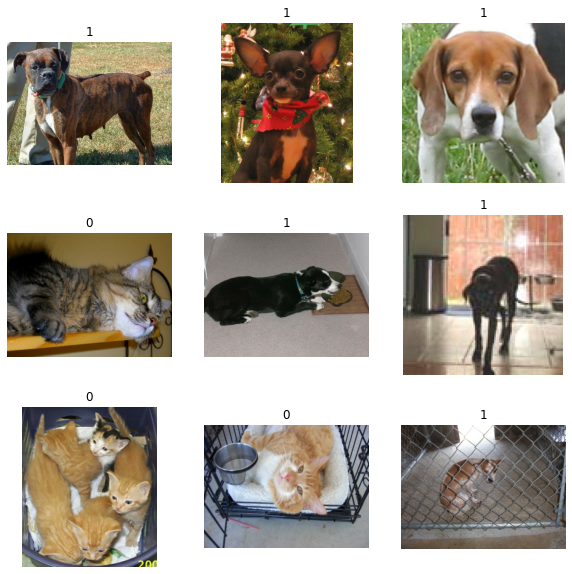

In [6]:
# Reference: https://keras.io/guides/transfer_learning/
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis('off')

In [0]:
IMG_SHAPE = 128
BS = 64
AUTO = tf.data.experimental.AUTOTUNE

@tf.function
def preprocess_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (IMG_SHAPE, IMG_SHAPE))

    return (image, label)

train_ds = (
    train_ds
    .map(preprocess_image, num_parallel_calls=AUTO)
    .shuffle(100)
    .batch(BS)
    .prefetch(AUTO)
)

validation_ds = (
    validation_ds
    .map(preprocess_image, num_parallel_calls=AUTO)
    .shuffle(100)
    .batch(BS)
    .prefetch(AUTO)
)

## Model building and training

In [0]:
def get_training_model(optimizer=tf.keras.optimizers.Adam()):
    resnet50 = tf.keras.applications.ResNet50(weights=None, include_top=False)

    model = tf.keras.Sequential([
        resnet50,
        GlobalAveragePooling2D(),
        Dropout(0.2),
        Dense(1)
    ])

    model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
    
    return model

In [10]:
wandb.init(project="scl", entity="authors", id="fully-supervised-pets")
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2,
	restore_best_weights=True, verbose=2)

model = get_training_model()

start = time.time()
model.fit(train_ds,
          validation_data=validation_ds,
          epochs=50,
          callbacks=[WandbCallback(), es])
end = time.time()
wandb.log({"training_time": end - start})

Epoch 1/50
309/309 [==============================] - 82s 266ms/step - loss: 0.7199 - binary_accuracy: 0.6348 - val_loss: 0.6751 - val_binary_accuracy: 0.5586
Epoch 2/50
309/309 [==============================] - 79s 256ms/step - loss: 0.5520 - binary_accuracy: 0.7151 - val_loss: 0.6510 - val_binary_accuracy: 0.6136
Epoch 3/50
309/309 [==============================] - 76s 248ms/step - loss: 0.4721 - binary_accuracy: 0.7703 - val_loss: 0.6784 - val_binary_accuracy: 0.6624
Epoch 4/50
309/309 [==============================] - 78s 253ms/step - loss: 0.3957 - binary_accuracy: 0.8138 - val_loss: 0.7286 - val_binary_accuracy: 0.7529
Epoch 00004: early stopping


What happens if we don't incorporate the `EarlyStopping` callback?

In [11]:
wandb.init(project="scl", entity="authors", id="fully-supervised-pets-no-es")

no_es_model = get_training_model()

start = time.time()
no_es_model.fit(train_ds,
          validation_data=validation_ds,
          epochs=50,
          callbacks=[WandbCallback()])
end = time.time()
wandb.log({"training_time": end - start})

Epoch 1/50
309/309 [==============================] - 81s 262ms/step - loss: 0.8102 - binary_accuracy: 0.5637 - val_loss: 0.7954 - val_binary_accuracy: 0.4953
Epoch 2/50
309/309 [==============================] - 79s 255ms/step - loss: 0.6461 - binary_accuracy: 0.6488 - val_loss: 0.6386 - val_binary_accuracy: 0.6314
Epoch 3/50
309/309 [==============================] - 77s 250ms/step - loss: 0.5960 - binary_accuracy: 0.6876 - val_loss: 0.9862 - val_binary_accuracy: 0.6073
Epoch 4/50
309/309 [==============================] - 80s 258ms/step - loss: 0.5659 - binary_accuracy: 0.7080 - val_loss: 0.5335 - val_binary_accuracy: 0.7403
Epoch 5/50
309/309 [==============================] - 78s 252ms/step - loss: 0.5271 - binary_accuracy: 0.7296 - val_loss: 0.5722 - val_binary_accuracy: 0.7102
Epoch 6/50
309/309 [==============================] - 79s 256ms/step - loss: 0.4853 - binary_accuracy: 0.7583 - val_loss: 0.7434 - val_binary_accuracy: 0.6346
Epoch 7/50
309/309 [==========================

## Serialize the model weights to GCS

In [12]:
from google.colab import auth
auth.authenticate_user()

PROJECT_ID = "fast-ai-exploration" 
!gcloud config set project $PROJECT_ID

Updated property [core/project].


In [0]:
time_now = time.time()
no_es_model.save("fully_supervised_" + str(time_now) + ".h5")

!gsutil -m cp -r *.h5 gs://supervised-contrastive/